In [7]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import torch

%matplotlib inline

# Decentralized Gradient under regular dynamic topology

**[TODO] Introduce the regular graph and why we don't need another correction in this case it can work.**

**[TODO] Update the APIs introduction**


After introducing the average consensus over the dynamic one peer strategy of exponential graph, it is natural to apply that on the Adapt-With-Combine algorithm as well. It is simply just

$$
    x_{k+1,i} = \sum_{j \in \mathcal{N}_i} w^{(k)}_{ij}x_{k,j} - \alpha \nabla f_i(x_{k,i}) 
$$

noting that we change from the static weights $w_{ij}$ to dynamic $w^{(k)}_{ij}$ and if step size $\alpha$ is zero or $f$ is constant, it regresses to average consensus problem. In order to achieve that in BlueFog, you need to specifiy the weights argument in the `neighbor_allreduce` function. Recall the full function signature is:

```
bf.neighbor_allreduce(
    tensor: torch.Tensor,
    self_weight: Union[float, NoneType] = None,
    neighbor_weights: Union[Dict[int, float], NoneType] = None,
    send_neighbors: Union[List[int], NoneType] = None,
    enable_topo_check: bool = True,
    name: Union[str, NoneType] = None,
) -> torch.Tensor
```
Different from the static case, you need to give different `self_weight`, `neighbor_weights`, and `send_neigbors` in each iteration. 

**Note:** the argument `send_neigbors`, which is the list of ranks sending to, is necessary for dynamic topology.

Since the design of BlueFog is to sperate the communication functionality from the topology usage, you need to explicitly to create these arguments for the `neighbor_allreduce` function. The code can be boilerplate and not straight-forward to write. Hence, we provide several topology utility functions for several common dynamic topology cases. Previous dynamic one peer strategy is definitely covered -- `topology_util.GetDynamicOnePeerSendRecvRanks`.

It is not a function but [generator](https://docs.python.org/3/tutorial/classes.html#generators) actually. If you are not familar with the concept of generator, don't be afraid. It is easy. Check the following example

In [1]:
import ipyparallel as ipp

rc = ipp.Client(profile="bluefog")

In [2]:
%%px
import torch
import bluefog.torch as bf
from bluefog.common import topology_util
bf.init()

print(f"Rank: {bf.rank()}, Size: {bf.size()}")

[stdout:0] Rank: 6, Size: 8
[stdout:1] Rank: 3, Size: 8
[stdout:2] Rank: 1, Size: 8
[stdout:3] Rank: 5, Size: 8
[stdout:4] Rank: 4, Size: 8
[stdout:5] Rank: 2, Size: 8
[stdout:6] Rank: 0, Size: 8
[stdout:7] Rank: 7, Size: 8


In [3]:
%%px
data_size = 100
seed = 1234
max_iters = 10
torch.random.manual_seed(seed * bf.rank())

x = torch.randn(data_size, dtype=torch.double)
x_bar = bf.allreduce(x, average=True)
mse = [torch.norm(x-x_bar, p=2) / torch.norm(x_bar, p=2)]

In [4]:
%%px

dynamic_neighbor_allreduce_gen = topology_util.GetDynamicOnePeerSendRecvRanks(
    bf.load_topology(), bf.rank())

for ite in range(max_iters):
    send_neighbors, recv_neighbors = next(dynamic_neighbor_allreduce_gen)
    uniform_weight = 1/(len(recv_neighbors) + 1)
    neighbor_weights = {r: uniform_weight for r in recv_neighbors}
    self_weight = uniform_weight

    x = bf.neighbor_allreduce(x, name='x', self_weight=self_weight,
                              src_weights=neighbor_weights,
                              dst_weights=send_neighbors, enable_topo_check=True)
    mse.append(torch.norm(x-x_bar, p=2) / torch.norm(x_bar, p=2))

In [5]:
mse = rc[0].pull("mse", block=True)

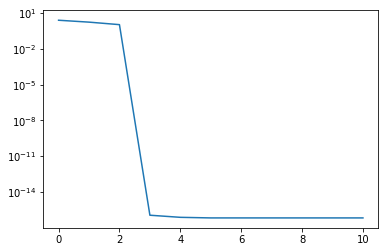

In [8]:
plt.semilogy(mse)

Above figure clearly illustrated the lemma in previous section -- the algorithm will reach the consensus under `log(bf.size())` step. In our case, just 2 steps.

Next, we show the performance comparison between static and dynamic topology over linear cost function.

In [9]:
num_data = 2400
dimension = 10
noise_level = 0.1
X = np.random.randn(num_data, dimension)
x_o = np.random.randn(dimension, 1)
ns = noise_level*np.random.randn(num_data,1)
y = X.dot(x_o) + ns

# We know the optimal solution in close form solution.
x_opt = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

For simplicity, we just use centralized solution to generate the data and distributed the partial data to all workers. Each worker should only contain `1/len(works)` number of all data.

In [10]:
num_workers = len(rc.ids)
assert num_data % num_workers == 0, \
    "Please adjust number of data so that it is the multiples of number of workers"

x_opt_torch = torch.from_numpy(x_opt)
for i in range(num_workers):
    X_partial = torch.from_numpy(X[i::num_workers])
    y_partial = torch.from_numpy(y[i::num_workers])
    rc[i].push({
        "X": X_partial,
        "y": y_partial,
        "x_opt": x_opt_torch
    }, block=True)

/Users/ybc/anaconda3/envs/bf_test/lib/python3.7/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


In [11]:
%px print(X.shape, y.shape)

[stdout:0] torch.Size([300, 10]) torch.Size([300, 1])
[stdout:1] torch.Size([300, 10]) torch.Size([300, 1])
[stdout:2] torch.Size([300, 10]) torch.Size([300, 1])
[stdout:3] torch.Size([300, 10]) torch.Size([300, 1])
[stdout:4] torch.Size([300, 10]) torch.Size([300, 1])
[stdout:5] torch.Size([300, 10]) torch.Size([300, 1])
[stdout:6] torch.Size([300, 10]) torch.Size([300, 1])
[stdout:7] torch.Size([300, 10]) torch.Size([300, 1])


In [12]:
%%px
max_iters = 100

mse_dynamic = []
mse_static = []

bf.set_topology(topology_util.ExponentialTwoGraph(bf.size()))
dynamic_neighbor_allreduce_gen = topology_util.GetDynamicOnePeerSendRecvRanks(
    bf.load_topology(), bf.rank())

x_static = torch.randn(x_opt.shape, dtype=torch.double)
x_dynamic = torch.randn(x_opt.shape, dtype=torch.double)
step_size = 0.0005

for ite in range(max_iters):
    send_neighbors, recv_neighbors = next(dynamic_neighbor_allreduce_gen)
    uniform_weight = 1 / (len(recv_neighbors) + 1)
    neighbor_weights = {r: uniform_weight for r in recv_neighbors}
    self_weight = uniform_weight

    x_dynamic = x_dynamic - step_size * X.T.mm(X.mm(x_dynamic) - y)
    x_dynamic = bf.neighbor_allreduce(x_dynamic,
                                      name='x_dynamic',
                                      self_weight=self_weight,
                                      src_weights=neighbor_weights,
                                      dst_weights=send_neighbors,
                                      enable_topo_check=True)

    x_static = x_static - step_size * X.T.mm(X.mm(x_static) - y)
    x_static = bf.neighbor_allreduce(x_static, name='x_static')

    mse_dynamic.append(
        torch.norm(x_dynamic - x_opt, p=2) / torch.norm(x_opt, p=2))
    mse_static.append(
        torch.norm(x_static - x_opt, p=2) / torch.norm(x_opt, p=2))

In [13]:
mse_dynamic, mse_static = rc[0].pull(["mse_dynamic", "mse_static"], block=True)

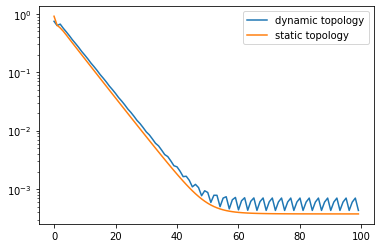

In [14]:
plt.semilogy(mse_dynamic, label="dynamic topology")
plt.semilogy(mse_static, label="static topology")
plt.legend()